In [144]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [145]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod3(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual3(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod3(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]


def residual_p_cygni(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    intensity = temp(wav, T)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = N*intensity*(correction-1)
    
    if data is None:
        return intensity
    return (model - data)/error

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, 
                    v_out_n=0.2, v_phot_n=0.1, tau_n=0.2, lambda_n=7500, ve_n=0.1, occul_n=1
                   
                   ): 
    intensity = temp(wav, T)

    pcyg_prof_n = p_cygni_line_corr(wav, v_out_n, v_phot_n, tau_n   , lambda_n, vref=vref, ve=ve_n , t0=t0)
    pcyg_prof_n[pcyg_prof_n>1] = (pcyg_prof_n[pcyg_prof_n>1]-1)*occul_n + 1

    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction * pcyg_prof_n
    return N*intensity+gau1+gau2

def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2 = v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    v_out_n, v_phot_n, tau_n, lambda_n, ve_n = v["v_out_n"], v["v_phot_n"], v["tau_n"], v["lambda_n"], v["ve_n"]
    occul_n = v["occul_n"]

    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, 
                           v_out_n=v_out_n, v_phot_n=v_phot_n, tau_n=tau_n, lambda_n=lambda_n, ve_n=ve_n, occul_n=occul_n)
    
    if data is None:
        return model
    return (model - data)/error

In [146]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[3]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 6000) & (x[:,0] < 8500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl4, flux4, error4 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB4/OB4_3_peaks_with_gaussian.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl4*1e-10)
#error4 = error4*np.sqrt(1.51)

np.mean((flux4-flux_fit)**2/error4**2)

C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


1.5831547549336247

In [131]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl4*1e-10)
    return lnprob_inner(model, flux4, error4)

pickle_in = open("./data/OB4/OB4_two_Pcygni_200x2500_lambda0free_7505.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('occul_n', 1); p['occul_n'].vary=False

p['vphot'].vary=False
p['vmax'].vary=False
p['tau'].vary=False
p['ve'].vary=False
p['occult'].vary=False
p['amp1'].vary=False
p['amp2'].vary=False
p['sig1'].vary=False
p['sig2'].vary=False

mini = lmfit.Minimizer(lnprob, p)
#nwalkers = 50 
res4_2 = mini.emcee(nwalkers=15, burn=0, steps=1200, thin=1, params=p, seed=2, workers = 4)

#print('Time elapsed [hours]:',(end-start)/60/60 )

p

C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
  1%|▏         | 17/1200 [00:06<08:39,  2.28it/s]C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
 76%|███████▌  | 908/1200 [07:46<02:56,  1.65it/

The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 24;
tau: [ 71.64578341  69.96570249  86.04937689 100.4615677  111.51415428
  63.89477741  95.59029552]


name,value,standard error,relative error,initial value,min,max,vary
T,3233.15581,1.64729253,(0.05%),3234.3962625116383,2500.00000,7500.00000,True
N,3.1242e-29,8.6405e-32,(0.28%),3.120739634650253e-29,-inf,inf,True
vphot,0.17633126,0.00105945,(0.60%),0.17656698606872984,0.00000000,1.00000000,False
vmax,0.23100437,6.3961e-04,(0.28%),0.23116715937497467,0.00000000,1.00000000,False
t0,385200.000,,(0.28%),385200,-inf,inf,False
tau,0.38078041,0.00839126,(2.20%),0.3851950743930552,0.00000000,10.0000000,False
vref,0.00000000,,(2.20%),0.0,0.00000000,1.00000000,False
ve,12.1797593,4.75959543,(39.08%),10.769461133136815,0.00000000,20.0000000,False
occult,7.77784665,0.10087315,(1.30%),7.713599721736371,0.10000000,20.0000000,False
amp1,0.96374711,0.00615141,(0.64%),0.9638186217705084,0.01000000,5.00000000,False


In [137]:
res4_2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3211.00524,6.46520243,(0.20%),3233.1558075158105,2500.00000,7500.00000,True
N,3.2372e-29,3.9377e-31,(1.22%),3.1242381060854996e-29,-inf,inf,True
vphot,0.17633126,,(1.22%),0.17633125939843924,0.00000000,1.00000000,False
vmax,0.23100437,,(1.22%),0.23100437142166136,0.00000000,1.00000000,False
t0,385200.000,,(1.22%),385200,-inf,inf,False
tau,0.38078041,,(1.22%),0.3807804147938671,0.00000000,10.0000000,False
vref,0.00000000,,(1.22%),0.0,0.00000000,1.00000000,False
ve,12.1797593,,(1.22%),12.17975930898075,0.00000000,20.0000000,False
occult,7.77784665,,(1.22%),7.777846646040826,0.10000000,20.0000000,False
amp1,0.96374711,,(1.22%),0.9637471137263789,0.01000000,5.00000000,False


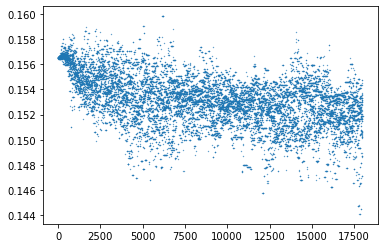

In [138]:
flat = res4_2.flatchain

plt.scatter(np.arange(len(flat['v_phot_n'])), flat['v_phot_n'], s=0.1)

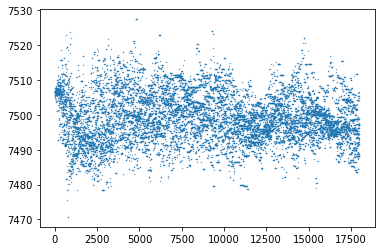

In [139]:
plt.scatter(np.arange(len(flat['v_phot_n'])), flat['lambda_n'], s=0.1)

In [140]:
#The New Chi^2

flux_fit = residual(res4_2.params, wl4*1e-10)
np.mean((flux4-flux_fit)**2/error4**2)

1.1974728245966493

In [141]:
N_1      = np.median( np.array(flat['N'])     )
v_phot_1 = np.median( np.array(flat['v_phot_n']) )
R_1 = np.sqrt( np.array(N_1)*10**7  ) *(43*3.086e+24)
v_sn_1 = R_1/4.4/(24*3600*3e10)/inter(v_phot_1)**2

v_sn_1, np.median(flat['v_phot_n'])

(0.16757748456328364, 0.15318529720075602)

In [142]:
(0.16757748456328364-0.15318529720075602)/(0.16757748456328364+0.15318529720075602)

0.04486863246221264

In [149]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[4]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl5, flux5, error5 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


pickle_in = open("./data/OB5/OB5_3_peaks_with_gaussian.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl5*1e-10)
error5 = error5*np.sqrt(1.95)

np.mean((flux5-flux_fit)**2/error5**2)

1.0021991935657175

In [202]:
def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl5*1e-10)
    return lnprob_inner(model, flux5, error5)

pickle_in = open("./Data/OB5/OB5_lambdafixed_7505_final_long.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('occul_n', 1); p['occul_n'].vary=False
#p['occul_n'].vary=False; p['occul_n'].value=1

#p['vphot'].vary=False
#p['vmax'].vary=False
#p['tau'].vary=False
#p['ve'].vary=False
#p['occult'].vary=False
#p['amp1'].vary=False
#p['amp2'].vary=False
#p['sig1'].vary=False
#p['sig2'].vary=False
#p['lambda_n'].vary=False
p['lambda_n'].value=7505
#p['lambda_n'].max=7515
#p['lambda_n'].max=7495

mini = lmfit.Minimizer(lnprob, p)
#nwalkers = 50 
res5_5 = mini.emcee(nwalkers=50, burn=0, steps=1000, thin=1, params=p, seed=2, workers = 4)

#print('Time elapsed [hours]:',(end-start)/60/60 )

p

100%|██████████| 1000/1000 [27:11<00:00,  1.63s/it] 

The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 78.04251289  81.13595323 112.61711965 113.3582255  132.71782504
 131.36715821  77.6501202   83.50201284  79.39964536  90.76412046
 101.8595206  127.99769499  92.59257999]


name,value,standard error,relative error,initial value,min,max,vary
T,3097.83360,2.33466857,(0.08%),3097.003367072263,2500.00000,7500.00000,True
N,3.5115e-29,1.2901e-31,(0.37%),3.5146868005708633e-29,-inf,inf,True
vphot,0.14779076,0.00182026,(1.23%),0.14990972428956795,0.00000000,1.00000000,True
vmax,0.23666794,0.00268250,(1.13%),0.24002109835294033,0.00000000,1.00000000,True
t0,466560.000,,(1.13%),466560,-inf,inf,False
tau,0.25926331,0.05647846,(21.78%),0.3188041208882464,0.00000000,10.0000000,True
vref,0.00000000,,(21.78%),0.0,0.00000000,1.00000000,False
ve,0.21899177,0.05794704,(26.46%),0.17934096486268003,0.00000000,20.0000000,True
occult,19.8901412,0.09711411,(0.49%),19.876139516091197,0.10000000,20.0000000,True
amp1,1.18420034,0.00650242,(0.55%),1.184477593161495,0.01000000,5.00000000,True


In [205]:
res5_5.params

name,value,standard error,relative error,initial value,min,max,vary
T,3098.10092,1.97785657,(0.06%),3097.8336038654897,2500.00000,7500.00000,True
N,3.5100e-29,1.1736e-31,(0.33%),3.511504609766384e-29,-inf,inf,True
vphot,0.14744927,0.00103567,(0.70%),0.14779076104111685,0.00000000,1.00000000,True
vmax,0.23617855,0.00147242,(0.62%),0.23666794030150187,0.00000000,1.00000000,True
t0,466560.000,,(0.62%),466560,-inf,inf,False
tau,0.25185371,0.02178107,(8.65%),0.2592633066637033,0.00000000,10.0000000,True
vref,0.00000000,,(8.65%),0.0,0.00000000,1.00000000,False
ve,0.22646481,0.02842630,(12.55%),0.2189917679957177,0.00000000,20.0000000,True
occult,19.9102100,0.07545667,(0.38%),19.890141190949837,0.10000000,20.0000000,True
amp1,1.18486647,0.00667577,(0.56%),1.1842003358525304,0.01000000,5.00000000,True


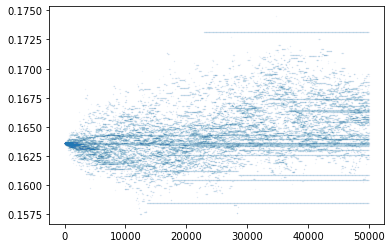

In [206]:
flat = res5_5.flatchain

plt.scatter(np.arange(len(flat['v_phot_n'])), flat['v_phot_n'], s=0.1, alpha=0.1)

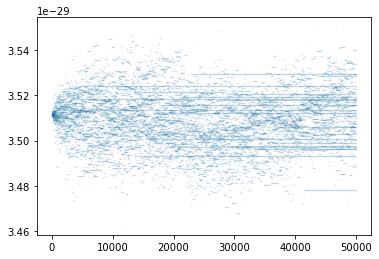

In [207]:
plt.scatter(np.arange(len(flat['v_phot_n'])), flat['N'], s=0.1, alpha=0.1)

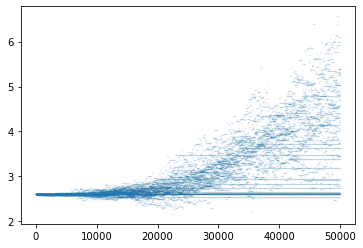

In [209]:
plt.scatter(np.arange(len(flat['v_phot_n'])), flat['tau_n'], s=0.1, alpha=0.1)

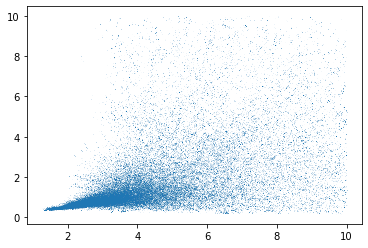

In [201]:
plt.scatter(flat['tau_n'], flat['ve_n'], s=0.01, alpha=0.1)

In [198]:
#with open("./Data/OB5/OB5_lambdafixed_7505_final_long.pkl", 'wb') as outfile:
#    pickle.dump(res5_4, outfile) 

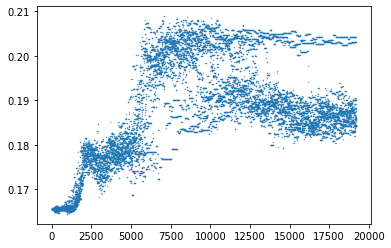

In [115]:
flat = res5_2.flatchain

plt.scatter(np.arange(len(flat['v_phot_n'])), flat['v_phot_n'], s=0.1)

(7690.378297227835, 20.734759584460598)

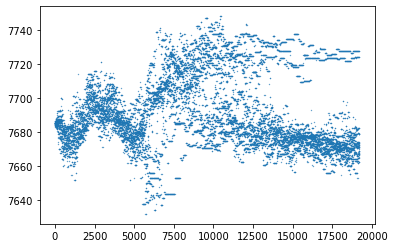

In [116]:
plt.scatter(np.arange(len(flat['v_phot_n'])), flat['lambda_n'], s=0.1)
np.mean(flat['lambda_n']), np.std(flat['lambda_n'])

In [117]:
#The New Chi^2

flux_fit = residual(res5_2.params, wl5*1e-10)
np.mean((flux5-flux_fit)**2/error5**2)

1.2095956167726827

In [121]:
N_1      = np.median( np.array(flat['N'])     )
v_phot_1 = np.median( np.array(flat['v_phot_n']) )
R_1 = np.sqrt( np.array(N_1)*10**7  ) *(43*3.086e+24)
v_sn_1 = R_1/4.4/(24*3600*3e10)/inter(v_phot_1)**2

v_sn_1, np.median(flat['v_phot_n'])#, np.median(flat['v_phot'])

(0.16799813371460343, 0.18760623462009854)

In [124]:
(0.16799813371460343-0.18760623462009854)/((0.16799813371460343+0.18760623462009854))

-0.055140213820544445

In [175]:
pickle_in = open("./Data/OB5/OB5_two_Pcygni_28x2000_lambda0_7500.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p

name,value,standard error,relative error,initial value,min,max,vary
T,3100.53125,8.39797335,(0.27%),3141.0340413504096,2500.00000,7500.00000,True
N,3.5107e-29,5.8455e-31,(1.67%),3.2997462185092304e-29,-inf,inf,True
vphot,0.09569230,0.01893791,(19.79%),0.13597211252666147,0.00000000,1.00000000,True
vmax,0.23005454,0.01468732,(6.38%),0.24234851532195964,0.00000000,1.00000000,True
t0,466560.000,,(6.38%),466560,-inf,inf,False
tau,0.22009154,0.01302622,(5.92%),0.3295510374085223,0.00000000,10.0000000,True
vref,0.00000000,,(5.92%),0.0,0.00000000,1.00000000,False
ve,0.25005202,0.06379567,(25.51%),0.4331928318929506,0.00000000,20.0000000,True
occult,9.53185406,0.58979506,(6.19%),8.375119546011277,0.10000000,20.0000000,True
amp1,1.17168747,0.03109145,(2.65%),1.2456363950993357,0.01000000,5.00000000,True


In [176]:
pickle_in = open("./Data/OB5/OB5_two_Pcygni_28x2000_lambda0_7500.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p

name,value,standard error,relative error,initial value,min,max,vary
T,3100.53125,8.39797335,(0.27%),3141.0340413504096,2500.00000,7500.00000,True
N,3.5107e-29,5.8455e-31,(1.67%),3.2997462185092304e-29,-inf,inf,True
vphot,0.09569230,0.01893791,(19.79%),0.13597211252666147,0.00000000,1.00000000,True
vmax,0.23005454,0.01468732,(6.38%),0.24234851532195964,0.00000000,1.00000000,True
t0,466560.000,,(6.38%),466560,-inf,inf,False
tau,0.22009154,0.01302622,(5.92%),0.3295510374085223,0.00000000,10.0000000,True
vref,0.00000000,,(5.92%),0.0,0.00000000,1.00000000,False
ve,0.25005202,0.06379567,(25.51%),0.4331928318929506,0.00000000,20.0000000,True
occult,9.53185406,0.58979506,(6.19%),8.375119546011277,0.10000000,20.0000000,True
amp1,1.17168747,0.03109145,(2.65%),1.2456363950993357,0.01000000,5.00000000,True
